In [1]:
from home_cage_prediction.load.etoh import load_home_cage_data, load_etoh_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.base import clone
from sklearn.compose import ColumnTransformer

In [2]:
def drop_agg(df_hc: pd.DataFrame, drop: bool = False):
    AGG_COLS = ["agg_explore", "agg_cons", "agg_low"]
    if drop:
        df_hc = df_hc.drop(columns=AGG_COLS)
    return df_hc


def identity(df: pd.DataFrame) -> pd.DataFrame:
    return df


DATA_DIR = Path(os.environ.get("DATA_DIR")) / "raw"

In [3]:
df_etoh = load_etoh_data(data_dir=DATA_DIR).melt(
    id_vars="mouse_name", var_name="week", value_name="etoh-consumption"
)

df_hc_base = load_home_cage_data(data_dir=DATA_DIR, week="hc-base")


def load_hc_data(data_dir: Path, sub_base: bool = False):
    df_base = load_home_cage_data(data_dir=data_dir, week="hc-base")
    frames = []
    for week in ("hc-week-1", "hc-week-2", "hc-week-3"):
        frame = load_home_cage_data(data_dir=data_dir, week=week)
        if sub_base:
            frame = frame.set_index("mouse_name") - df_base.set_index("mouse_name")
            frame = frame.reset_index()
        frame["week"] = "_".join(week.split("-")[1:])
        frames.append(frame)
    return pd.concat(frames)


df_hc = load_hc_data(data_dir=DATA_DIR, sub_base=True)

df = df_hc.merge(df_etoh)

<Axes: >

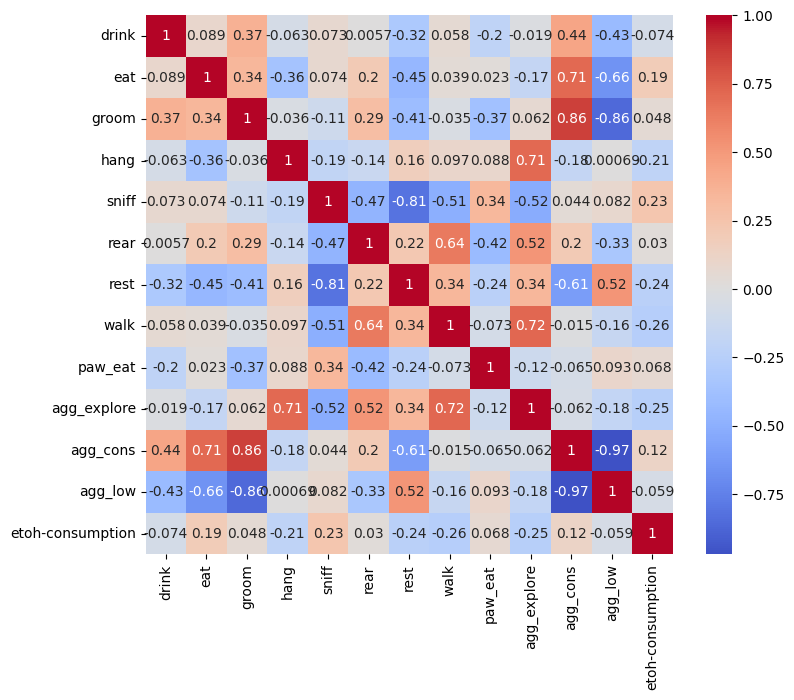

In [4]:
fig, ax = plt.subplots(figsize=(8.5, 7))
sns.heatmap(
    df.drop(columns=["mouse_name", "week"]).corr(),
    annot=True,
    center=0,
    cmap="coolwarm",
    ax=ax,
)

R2: 0.50


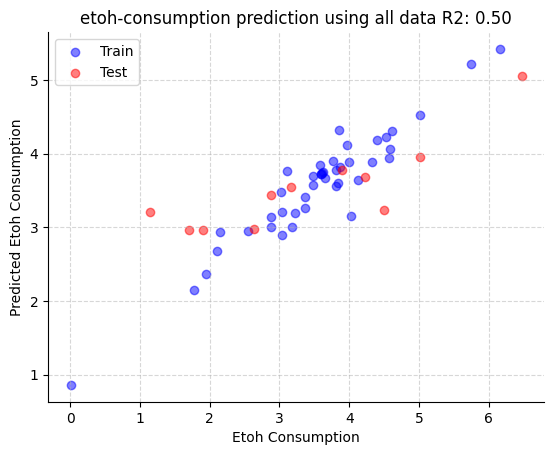

In [24]:
cat_cols = ["mouse_name", "week"]
target_col = "etoh-consumption"


cat_pipe = Pipeline(
    [
        ("one_hot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

num_pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
    ]
)
preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, df.drop(columns=cat_cols + [target_col]).columns),
        ("cat", cat_pipe, cat_cols),
    ]
)

pipe = Pipeline(
    [
        ("preprocess", preprocess),
        # ("poly", PolynomialFeatures(interaction_only=True)),
        # ("model", LinearRegression()),
        ("model", RandomForestRegressor(n_estimators=30, max_depth=5)),
    ]
)

cats, groups = np.unique(df["mouse_name"], return_inverse=True)

X = df.drop(columns=[target_col])
y = df[target_col]


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    # random_state=42,
    shuffle=True,
)


pipe.fit(X_train, y_train)
y_train_pred = pipe.predict(X_train)
y_pred = pipe.predict(X_test)
y_true = y_test
score_obs = r2_score(y_true, y_pred)
print(f"R2: {score_obs:.2f}")


# Create a scatter plot for the training set
plt.scatter(y_train, y_train_pred, color="blue", alpha=0.5, label="Train")

# Create a scatter plot for the test set
plt.scatter(y_test, y_pred, color="red", alpha=0.5, label="Test")

# Add labels and title
plt.xlabel("Etoh Consumption")
plt.ylabel("Predicted Etoh Consumption")
plt.legend()

plt.grid(True, linestyle="--", alpha=0.5)
plt.title(f"{target_col} prediction using all data R2: {score_obs:.2f}")

sns.despine(ax=plt.gca())

In [26]:
from sklearn.model_selection import cross_val_score

cv = KFold(n_splits=5, shuffle=True)

pipe = clone(pipe)

scores = cross_val_score(pipe, X, y, cv=cv, scoring="r2")
print(f"R2: {scores.mean():.2f} +/- {scores.std():.2f}")

np.quantile(scores, [0.025, 0.975])

R2: 0.35 +/- 0.18


array([0.03789294, 0.52763756])

In [27]:
scores = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=True
    )
    pipe_i = clone(pipe)
    pipe_i.fit(X_train, y_train)
    y_pred = pipe_i.predict(X_test)
    y_true = y_test
    score = r2_score(y_true, y_pred)

    scores.append(score)

scores = np.array(scores)
print(f"R2: {scores.mean():.2f}")
np.quantile(scores, [0.025, 0.975])

R2: 0.13


array([-0.9184663 ,  0.58037902])